In [89]:
import scipy.io as sio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
import os
import time
from sklearn.utils.class_weight import compute_class_weight
import random
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

In [90]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # For deterministic behavior (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [91]:
# ======= 1. Dataset Loader =======
def load_dataset(name):
    if name == 'pavia':
        data = sio.loadmat('/content/PaviaU.mat')['paviaU'].astype(np.float32)
        gt = sio.loadmat('/content/PaviaU_gt.mat')['paviaU_gt']
    elif name == 'salinas':
        data = sio.loadmat('/content/Salinas_corrected.mat')['salinas_corrected'].astype(np.float32)
        gt = sio.loadmat('/content/Salinas_gt.mat')['salinas_gt']
    elif name == 'indian':
        data = sio.loadmat('/content/Indian_pines_corrected.mat')['indian_pines_corrected'].astype(np.float32)
        gt = sio.loadmat('/content/Indian_pines_gt.mat')['indian_pines_gt']
    else:
        raise ValueError("Unsupported dataset name")
    return data, gt

In [101]:
# ======= 2. Preprocessing =======
def preprocess(data, gt, dataset_name):
    h, w, bands = data.shape
    if dataset_name == 'indian':
        noisy_bands = [b for b in (list(range(104, 109)) + list(range(150, 164)) + [220]) if b < bands]
        data = np.delete(data, noisy_bands, axis=2)
    scaler = MinMaxScaler()
    data_reshaped = data.reshape(-1, data.shape[2])
    data_scaled = scaler.fit_transform(data_reshaped).astype(np.float32)
    pca_components = 30 if dataset_name != 'indian' else 40
    pca = PCA(n_components=pca_components)
    # pca = PCA(n_components=pca_components, svd_solver='full', random_state=42)
    data_pca = pca.fit_transform(data_scaled)
    data_pca = data_pca.reshape(h, w, -1)
    return data_pca, gt, h, w, pca_components

In [93]:
# ======= 3. Efficient Patch Extraction (Reduce Redundancy) =======
def extract_patches(data, gt, patch_size):
    h, w, c = data.shape
    margin = patch_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0,0)), mode='reflect')
    padded_gt = np.pad(gt, ((margin, margin), (margin, margin)), mode='reflect')

    # Vectorized patch extraction using stride tricks (fast and no Python loops)
    shape = (h, w, patch_size, patch_size, c)
    strides = (padded_data.strides[0], padded_data.strides[1], padded_data.strides[0], padded_data.strides[1], padded_data.strides[2])
    patches = np.lib.stride_tricks.as_strided(padded_data, shape=shape, strides=strides)
    patches = patches.reshape(-1, patch_size, patch_size, c)

    gt_flat = padded_gt[margin:margin+h, margin:margin+w].flatten()

    # Only keep patches for pixels with ground truth labels != 0 (Reduce redundancy)
    idx = np.where(gt_flat != 0)[0]
    patches = patches[idx]
    labels = gt_flat[idx]
    coords = np.array([(i // w, i % w) for i in idx])
    return patches, labels, coords, h, w


In [94]:
# ======= 4. Optimized Autoencoder Architecture =======
class PatchAutoencoder(nn.Module):
    def __init__(self, latent_dim, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 512),  # reduced from 512
            nn.ReLU(),
            nn.Linear(512, latent_dim)  # latent_dim typically 32
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z


In [95]:
# ======= 5. Transformer with Batched Scoring =======
class SimpleTransformer(nn.Module):
    def __init__(self, dim=32, heads=4):  # heads reduced from 8 to 4 for speed
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, z):
        z = z.unsqueeze(1)  # add sequence dimension
        attn_out, _ = self.attn(z, z, z)
        squeezed = attn_out.squeeze(1)
        scores = self.linear(squeezed).squeeze()
        return scores

In [96]:
# ======= 6. Latent Space Visualization (Optimized t-SNE) =======
def visualize_latent_space(z, labels, dataset_name):
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', n_iter=500)
    z_2d = tsne.fit_transform(z)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='tab20', s=5)
    plt.title(f"Latent Space t-SNE Visualization - {dataset_name.upper()}")
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.savefig(f"outputs/{dataset_name}_latent_tsne.png")
    plt.close()

In [97]:
# ==== Additional EarlyStopping Utility ====
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [98]:
set_seed(42)

In [102]:
# ======= 7. Main Pipeline (with all optimizations) =======
def run_pipeline(dataset_name, patch_size=16, latent_dim=32, num_epochs=10, save_rgb=True):
    os.makedirs("outputs", exist_ok=True)
    torch.cuda.empty_cache()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("Loading dataset and preprocessing...")
    data, gt = load_dataset(dataset_name)
    data_pca, gt, h, w, pca_dim = preprocess(data, gt, dataset_name)

    # if save_rgb:
    rgb_image = data_pca[:, :, :3]
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
    plt.imsave(f"outputs/{dataset_name}_pca_rgb.png", rgb_image)
    plt.figure(figsize=(6, 6))
    plt.title(f"{dataset_name} PCA RGB Visualization")
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.show()

    input_dim = patch_size * patch_size * pca_dim
    patches, labels, coords, h, w = extract_patches(data_pca, gt, patch_size=patch_size)

    print(f"Extracted {len(patches)} patches with known labels (no redundancy).")

    # Convert patches to tensor, flatten patches to vectors
    patches_tensor = torch.tensor(patches, dtype=torch.float32).reshape(-1, input_dim)
    dataset = TensorDataset(patches_tensor)
    batch_size = 512

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    model = PatchAutoencoder(latent_dim=latent_dim, input_dim=input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scaler = torch.cuda.amp.GradScaler()
    early_stopping = EarlyStopping(patience=3)

    print("Training Autoencoder with mixed precision and batching...")
    model.train()
    # scaler = torch.cuda.amp.GradScaler()
    epoch_losses = []

    for epoch in range(1, num_epochs + 1):
        total_loss = 0
        for (batch,) in train_loader:
            batch = batch.to(device, non_blocking=True)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                output, _ = model(batch)
                loss = criterion(output, batch)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch}/{num_epochs} - Loss: {avg_loss:.6f}")

    # Save loss curve plot
    plt.figure()
    plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
    plt.title("Autoencoder Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.savefig(f"outputs/{dataset_name}_ae_loss_curve.png")
    plt.close()

    print("Extracting latent features...")
    model.eval()
    with torch.no_grad():
        _, latent_z = model(patches_tensor.to(device))
    latent_z = latent_z.cpu()

    print("Visualizing latent space with optimized t-SNE...")
    visualize_latent_space(latent_z.numpy(), labels, dataset_name)

    print("Running Transformer with batched scoring...")
    transformer = SimpleTransformer(dim=latent_dim).to(device)
    transformer.eval()
    trans_scores = []
    for i in range(0, latent_z.shape[0], batch_size):
        batch = latent_z[i:i+batch_size].to(device)
        with torch.no_grad():
            scores = transformer(batch).cpu().numpy()
        trans_scores.append(scores)
    trans_scores = np.concatenate(trans_scores)

    print("Creating anomaly map...")
    anomaly_map = np.zeros((h, w), dtype=np.float32)
    for idx, (x, y) in enumerate(coords):
        anomaly_map[x, y] = trans_scores[idx]
    anomaly_map_norm = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-8)

    # Overlay visualization skipped for RGB image if save_rgb is False
    if save_rgb:
        rgb_image = data_pca[:, :, :3]
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
    else:
        rgb_image = np.zeros((h, w, 3))  # dummy black image for overlay

    fig, axs = plt.subplots(1, 4, figsize=(20, 6))
    axs[0].imshow(gt, cmap='tab20')
    axs[0].set_title("Ground Truth")
    axs[0].axis('off')

    if save_rgb:
        axs[1].imshow(rgb_image)
        axs[1].set_title("RGB PCA Image")
    else:
        axs[1].text(0.5, 0.5, "RGB Image Save Disabled", ha='center', va='center', fontsize=12)
    axs[1].axis('off')

    im = axs[2].imshow(anomaly_map_norm, cmap='inferno')
    axs[2].set_title("Anomaly Heatmap")
    axs[2].axis('off')
    fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)

    axs[3].imshow(rgb_image)
    axs[3].imshow(anomaly_map_norm, cmap='inferno', alpha=0.4)
    axs[3].set_title("Overlay RGB + Anomalies")
    axs[3].axis('off')

    plt.tight_layout()
    plt.savefig(f"outputs/{dataset_name}_anomaly_map_overlay.png")
    plt.close()

    print("Training SVM on PCA-reduced latent features...")
    # pca_svm = PCA(n_components=min(latent_dim, 20))  # reduce dim before SVM
    # latent_reduced = pca_svm.fit_transform(latent_z.numpy())

    # X_train, X_test, y_train, y_test = train_test_split(latent_reduced, labels, test_size=0.25, random_state=42, stratify=labels)
    # svm_clf = SVC(kernel='rbf', C=5, gamma='scale')
    # svm_clf.fit(X_train, y_train)
    # y_pred = svm_clf.predict(X_test)
    pca_svm = PCA(n_components=min(latent_dim, 20))
    latent_reduced = pca_svm.fit_transform(latent_z.numpy())

    X_train, X_test, y_train, y_test = train_test_split(latent_reduced, labels, test_size=0.25, random_state=42, stratify=labels)
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: w for i, w in zip(np.unique(y_train), class_weights)}

    svm_clf = SVC(kernel='rbf', C=5, gamma='scale', class_weight=class_weight_dict, probability=True)
    svm_clf.fit(X_train, y_train)
    y_pred = svm_clf.predict(X_test)
    y_proba = svm_clf.predict_proba(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    try:
        auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
        ap = average_precision_score(y_test, y_proba, average='macro')
        print(f"AUC (macro-avg): {auc:.4f}")
        print(f"Average Precision (macro-avg): {ap:.4f}")
    except Exception as e:
        print("AUC/AP metrics failed:", e)


    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {dataset_name.upper()}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig(f"outputs/{dataset_name}_confusion_matrix.png")
    plt.close()

    print("Pipeline complete! Results saved in 'outputs/' directory.")


Loading dataset and preprocessing...


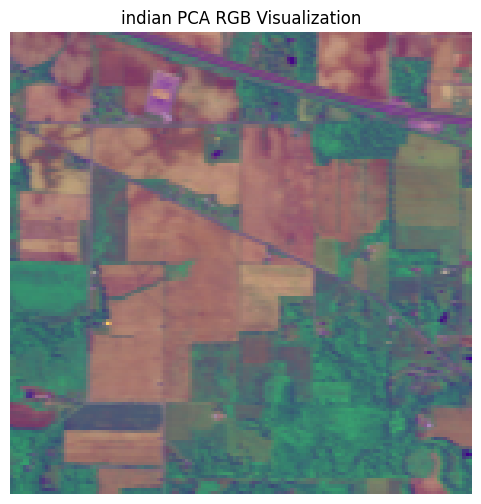

Extracted 10249 patches with known labels (no redundancy).


<ipython-input-102-6023e87022f0>:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-102-6023e87022f0>:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Autoencoder with mixed precision and batching...
Epoch 1/10 - Loss: 0.091961
Epoch 2/10 - Loss: 0.064671
Epoch 3/10 - Loss: 0.059694
Epoch 4/10 - Loss: 0.049890
Epoch 5/10 - Loss: 0.049274
Epoch 6/10 - Loss: 0.044841
Epoch 7/10 - Loss: 0.045690
Epoch 8/10 - Loss: 0.044958
Epoch 9/10 - Loss: 0.046190
Epoch 10/10 - Loss: 0.038916
Extracting latent features...
Visualizing latent space with optimized t-SNE...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Running Transformer with batched scoring...
Creating anomaly map...
Training SVM on PCA-reduced latent features...
Classification Report:
              precision    recall  f1-score   support

           1       0.92      1.00      0.96        11
           2       0.98      0.97      0.98       357
           3       0.99      0.99      0.99       208
           4       1.00      1.00      1.00        59
           5       0.99      0.99      0.99       121
           6       0.98      1.00      0.99       183
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00       120
           9       1.00      1.00      1.00         5
          10       0.93      0.98      0.96       243
          11       1.00      0.97      0.98       614
          12       0.98      1.00      0.99       148
          13       1.00      1.00      1.00        51
          14       1.00      1.00      1.00       316
          15       1.00      1.00      1.00        

In [104]:
if __name__ == "__main__":
    start_time = time.time()
    run_pipeline('indian', patch_size=16, latent_dim=32, num_epochs=10, save_rgb=True)
    print(f"Total runtime: {time.time() - start_time:.2f} seconds")